# Reinforcement Learning based recommender systems (Multi Armed Bandit Approach - Simplified Markov Decision Process)

In [217]:
# Importing the libraries
import pandas as pd
import numpy as np
from dateutil.parser import parse
import operator
from collections import Counter

In [49]:
# Read the data:
def readdata(path):
    orders = pd.read_csv(path, encoding = "ISO-8859-1")
    return orders

In [52]:
# Data input
orders = readdata('OnlineRetail.csv')
orders.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


In [53]:
# Use of inline functions to pull more information from existing data
orders["Parse_data"] = orders["InvoiceDate"].apply(lambda x:parse(x) )

In [54]:
orders["Weekday"] = orders["Parse_data"].apply(lambda x:x.weekday() )   # weekdays

orders["Day"] = orders["Parse_data"].apply(lambda x:x.strftime("%A"))   # Day of transaction

orders["Month"] = orders["Parse_data"].apply(lambda x:x.strftime("%B")) # Month 

orders["Year"] = orders["Parse_data"].apply(lambda x:x.strftime("%Y") ) # Year
 
orders["year_month"] = orders["Year"] + "_" + orders["Month"]           # Year Month combined

orders.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Parse_data,Weekday,Day,Month,Year,year_month
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom,2010-12-01 08:26:00,2,Wednesday,December,2010,2010_December
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom,2010-12-01 08:26:00,2,Wednesday,December,2010,2010_December
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom,2010-12-01 08:26:00,2,Wednesday,December,2010,2010_December
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom,2010-12-01 08:26:00,2,Wednesday,December,2010,2010_December
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom,2010-12-01 08:26:00,2,Wednesday,December,2010,2010_December


In [55]:
orders["Gross_value"] = orders["Quantity"]  * orders["UnitPrice"]   # Gross Value of product purchased

In [56]:
import lifetimes # New library to simplify the RFM studies (Recency | Frequency | Monetary Value)

In [57]:
RfmAgeTrain = lifetimes.utils.summary_data_from_transaction_data(orders, "CustomerID","Parse_data", "Gross_value")
RfmAgeTrain    # Result of RFM analysis

,frequency,recency,T,monetary_value
CustomerID,,,,
12346.0,0.0,0.0,325.0,0.000000
12347.0,6.0,365.0,367.0,599.701667
12348.0,3.0,283.0,358.0,301.480000
12349.0,0.0,0.0,18.0,0.000000
12350.0,0.0,0.0,310.0,0.000000
...,...,...,...,...
18280.0,0.0,0.0,277.0,0.000000
18281.0,0.0,0.0,180.0,0.000000
18282.0,2.0,119.0,126.0,38.195000


In [58]:
RfmAgeTrain = RfmAgeTrain.reset_index()
RfmAgeTrain

,CustomerID,frequency,recency,T,monetary_value
0,12346.0,0.0,0.0,325.0,0.000000
1,12347.0,6.0,365.0,367.0,599.701667
2,12348.0,3.0,283.0,358.0,301.480000
3,12349.0,0.0,0.0,18.0,0.000000
4,12350.0,0.0,0.0,310.0,0.000000
...,...,...,...,...,...
4367,18280.0,0.0,0.0,277.0,0.000000
4368,18281.0,0.0,0.0,180.0,0.000000
4369,18282.0,2.0,119.0,126.0,38.195000
4370,18283.0,13.0,334.0,337.0,152.802308


In [19]:
user_recency = RfmAgeTrain[["CustomerID","recency"]]
user_recency.head()

,CustomerID,recency
0,1,0.0
1,2,710.0
2,3,552.0
3,4,605.0
4,5,137.0


In [68]:
# Importing libraries for clustering and plotting
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

In [69]:
user_recency = RfmAgeTrain[['CustomerID', 'recency']]
user_recency.head()

,CustomerID,recency
0,12346.0,0.0
1,12347.0,365.0
2,12348.0,283.0
3,12349.0,0.0
4,12350.0,0.0


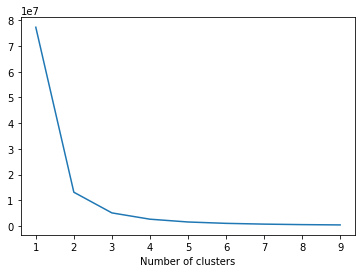

In [73]:
# Elbow method to get the number of possible splits in databb
sse = {}
recency = user_recency[['recency']]

for k in range(1,10):
    kmeans = KMeans(n_clusters = k, max_iter = 2000).fit(recency)
    sse[k] = kmeans.inertia_
    
plt.figure()
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of clusters")
plt.show()

2 is the perfect number of clusters, but furtherwe can see the elbow converging till 4 then flattening out. We can
therfore consider 4 number of clusters

In [74]:
recency

,recency
0,0.0
1,365.0
2,283.0
3,0.0
4,0.0
...,...
4367,0.0
4368,0.0
4369,119.0
4370,334.0


In [78]:
# Analysis and assigning clusters
kmeans = KMeans(n_clusters =4)
kmeans.fit(user_recency[['recency']])
user_recency['RecencyCluster'] = kmeans.predict(user_recency[['recency']])
user_recency

,CustomerID,recency,RecencyCluster
0,12346.0,0.0,1
1,12347.0,365.0,2
2,12348.0,283.0,2
3,12349.0,0.0,1
4,12350.0,0.0,1
...,...,...,...
4367,18280.0,0.0,1
4368,18281.0,0.0,1
4369,18282.0,119.0,3
4370,18283.0,334.0,2


In [79]:
user_recency.sort_values(by = 'recency', ascending = False).reset_index(drop= True)

,CustomerID,recency,RecencyCluster
0,13777.0,373.0,2
1,12748.0,373.0,2
2,15311.0,373.0,2
3,12433.0,373.0,2
4,12662.0,373.0,2
...,...,...,...
4367,16282.0,0.0,1
4368,16281.0,0.0,1
4369,13739.0,0.0,1
4370,16276.0,0.0,1


In [80]:
# recency cluster mean value
user_recency.groupby('RecencyCluster')['recency'].mean().reset_index()

,RecencyCluster,recency
0,0,228.101415
1,1,7.727087
2,2,334.934537
3,3,115.859854


In [81]:
def order_cluster(cluster_field_name,target_field_name, data, ascending):
    data_new = data.groupby(cluster_field_name)[target_field_name].mean().reset_index()
    
    data_new =  data_new.sort_values(by=target_field_name, ascending=ascending).reset_index(drop=True)
    
    data_new['index'] = data_new.index
    
    data_final = pd.merge(data, data_new[[cluster_field_name, 'index']], on=cluster_field_name)
    
    data_final = data_final.drop([cluster_field_name], axis=1)
    
    data_final = data_final.rename(columns = {'index':cluster_field_name })
    
    return data_final

In [82]:
user_recency = order_cluster('RecencyCluster','recency', user_recency,False)
user_recency.head()

,CustomerID,recency,RecencyCluster
0,12346.0,0.0,3
1,12349.0,0.0,3
2,12350.0,0.0,3
3,12353.0,0.0,3
4,12354.0,0.0,3


In [83]:
user_recency.groupby("RecencyCluster")['recency'].mean().reset_index()

,RecencyCluster,recency
0,0,334.934537
1,1,228.101415
2,2,115.859854
3,3,7.727087


In [84]:
def clusterSorter(target_field_name,ascending):
    user_variable =RfmAgeTrain[['CustomerID', target_field_name]]
    kmeans = KMeans(n_clusters=4)
    kmeans.fit(user_variable[[target_field_name]])
    cluster_field_name = target_field_name + "Cluster"
    user_variable[cluster_field_name] = kmeans.predict(user_variable[[target_field_name]])
    user_variable.sort_values(by = target_field_name, ascending = ascending).reset_index(drop = True)
    user_variable = order_cluster(cluster_field_name, target_field_name, user_variable,ascending)
    return user_variable

In [85]:
user_frequency = clusterSorter('frequency', True)
user_frequency.groupby('frequencyCluster')['frequency'].mean().reset_index()

,frequencyCluster,frequency
0,0,1.213047
1,1,7.814214
2,2,23.405063
3,3,92.333333


In [88]:
user_monetary = clusterSorter('monetary_value', True)
user_monetary.groupby('monetary_valueCluster')['monetary_value'].mean().reset_index()

,monetary_valueCluster,monetary_value
0,0,65.065513
1,1,430.864952
2,2,1746.756647
3,3,6900.334321


In [89]:
# Output of RFM analysis
RfmAgeTrain.head()

,CustomerID,frequency,recency,T,monetary_value
0,12346.0,0.0,0.0,325.0,0.000000
1,12347.0,6.0,365.0,367.0,599.701667
2,12348.0,3.0,283.0,358.0,301.480000
3,12349.0,0.0,0.0,18.0,0.000000
4,12350.0,0.0,0.0,310.0,0.000000


In [90]:
# Merging result of RFM analysis with the base file:
RfmAgeTrain = pd.merge(RfmAgeTrain,user_monetary[['CustomerID', 'monetary_valueCluster']], on = 'CustomerID')
RfmAgeTrain = pd.merge(RfmAgeTrain,user_frequency[['CustomerID', 'frequencyCluster']], on = 'CustomerID')
RfmAgeTrain = pd.merge(RfmAgeTrain,user_recency[['CustomerID', 'RecencyCluster']], on = 'CustomerID')
RfmAgeTrain.head()

,CustomerID,frequency,recency,T,monetary_value,monetary_valueCluster,frequencyCluster,RecencyCluster
0,12346.0,0.0,0.0,325.0,0.000000,0,0,3
1,12347.0,6.0,365.0,367.0,599.701667,1,1,0
2,12348.0,3.0,283.0,358.0,301.480000,1,0,0
3,12349.0,0.0,0.0,18.0,0.000000,0,0,3
4,12350.0,0.0,0.0,310.0,0.000000,0,0,3


In [92]:
# Calculating the overall score by adding RFM columns
RfmAgeTrain['OverallScore'] = (RfmAgeTrain['RecencyCluster'] + RfmAgeTrain['monetary_valueCluster'] 
                               + RfmAgeTrain['frequencyCluster'])
RfmAgeTrain

,CustomerID,frequency,recency,T,monetary_value,monetary_valueCluster,frequencyCluster,RecencyCluster,OverallScore
0,12346.0,0.0,0.0,325.0,0.000000,0,0,3,3
1,12347.0,6.0,365.0,367.0,599.701667,1,1,0,2
2,12348.0,3.0,283.0,358.0,301.480000,1,0,0,1
3,12349.0,0.0,0.0,18.0,0.000000,0,0,3,3
4,12350.0,0.0,0.0,310.0,0.000000,0,0,3,3
...,...,...,...,...,...,...,...,...,...
4367,18280.0,0.0,0.0,277.0,0.000000,0,0,3,3
4368,18281.0,0.0,0.0,180.0,0.000000,0,0,3,3
4369,18282.0,2.0,119.0,126.0,38.195000,0,0,2,2
4370,18283.0,13.0,334.0,337.0,152.802308,0,1,0,1


In [94]:
# Groupby Overallscore
RfmAgeTrain.groupby('OverallScore')['frequency','recency','monetary_value'].mean().reset_index()

,OverallScore,frequency,recency,monetary_value
0,0,2.537879,323.371212,153.399899
1,1,4.200680,279.767007,226.535568
2,2,5.198890,223.991674,297.902448
3,3,2.029716,48.291128,117.334099
4,4,6.982533,91.917031,600.088859
5,5,9.000000,107.157895,2285.510649
6,6,16.000000,97.000000,3568.791875


In [95]:
RfmAgeTrain.groupby('OverallScore')['frequency'].count().reset_index()

,OverallScore,frequency
0,0,132
1,1,588
2,2,1081
3,3,2322
4,4,229
5,5,19
6,6,1


In [98]:
# Creating a new column and assigning the customerpreferences into 4 segements:
RfmAgeTrain['Segment'] = 'Q1'
RfmAgeTrain.loc[(RfmAgeTrain.OverallScore == 0), 'Segment'] = 'Q2'
RfmAgeTrain.loc[(RfmAgeTrain.OverallScore == 1), 'Segment'] = 'Q2'
RfmAgeTrain.loc[(RfmAgeTrain.OverallScore == 2), 'Segment'] = 'Q3'
RfmAgeTrain.loc[(RfmAgeTrain.OverallScore == 4), 'Segment'] = 'Q4'
RfmAgeTrain.loc[(RfmAgeTrain.OverallScore == 5), 'Segment'] = 'Q4'
RfmAgeTrain.loc[(RfmAgeTrain.OverallScore == 6), 'Segment'] = 'Q4'

RfmAgeTrain

,CustomerID,frequency,recency,T,monetary_value,monetary_valueCluster,frequencyCluster,RecencyCluster,OverallScore,Segment
0,12346.0,0.0,0.0,325.0,0.000000,0,0,3,3,Q1
1,12347.0,6.0,365.0,367.0,599.701667,1,1,0,2,Q3
2,12348.0,3.0,283.0,358.0,301.480000,1,0,0,1,Q2
3,12349.0,0.0,0.0,18.0,0.000000,0,0,3,3,Q1
4,12350.0,0.0,0.0,310.0,0.000000,0,0,3,3,Q1
...,...,...,...,...,...,...,...,...,...,...
4367,18280.0,0.0,0.0,277.0,0.000000,0,0,3,3,Q1
4368,18281.0,0.0,0.0,180.0,0.000000,0,0,3,3,Q1
4369,18282.0,2.0,119.0,126.0,38.195000,0,0,2,2,Q3
4370,18283.0,13.0,334.0,337.0,152.802308,0,1,0,1,Q2


In [99]:
RfmAgeTrain.groupby('Segment')['frequency','recency','monetary_value'].mean().reset_index()

,Segment,frequency,recency,monetary_value
0,Q1,2.029716,48.291128,117.334099
1,Q2,3.895833,287.761111,213.127362
2,Q3,5.198890,223.991674,297.902448
3,Q4,7.172691,93.100402,740.617843


In [101]:
# Preparing the final processed dataset for RL analysis
custDetails = pd.merge(orders, RfmAgeTrain, on = ['CustomerID'], how = 'left')
custDetails.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Parse_data,Weekday,...,MonthPeriod,frequency,recency,T,monetary_value,monetary_valueCluster,frequencyCluster,RecencyCluster,OverallScore,Segment
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom,2010-12-01 08:26:00,2,...,0,2.0,71.0,373.0,1894.645,2.0,0.0,2.0,4.0,Q4
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom,2010-12-01 08:26:00,2,...,0,2.0,71.0,373.0,1894.645,2.0,0.0,2.0,4.0,Q4
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom,2010-12-01 08:26:00,2,...,0,2.0,71.0,373.0,1894.645,2.0,0.0,2.0,4.0,Q4
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom,2010-12-01 08:26:00,2,...,0,2.0,71.0,373.0,1894.645,2.0,0.0,2.0,4.0,Q4
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom,2010-12-01 08:26:00,2,...,0,2.0,71.0,373.0,1894.645,2.0,0.0,2.0,4.0,Q4


In [221]:
# Extracting final attributes from final dataset
custDetails["date"] = custDetails["Parse_data"].apply(lambda x: x.strftime('%d'))
custDetails["date"] = custDetails["date"].astype('float64')
custDetails["MonthPeriod"] =custDetails['date'].apply(lambda x: int(x > 15))   # Month

custDetails.head(10)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Parse_data,Weekday,...,MonthPeriod,frequency,recency,T,monetary_value,monetary_valueCluster,frequencyCluster,RecencyCluster,OverallScore,Segment
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom,2010-12-01 08:26:00,2,...,0,2.0,71.0,373.0,1894.645000,2.0,0.0,2.0,4.0,Q4
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom,2010-12-01 08:26:00,2,...,0,2.0,71.0,373.0,1894.645000,2.0,0.0,2.0,4.0,Q4
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom,2010-12-01 08:26:00,2,...,0,2.0,71.0,373.0,1894.645000,2.0,0.0,2.0,4.0,Q4
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom,2010-12-01 08:26:00,2,...,0,2.0,71.0,373.0,1894.645000,2.0,0.0,2.0,4.0,Q4
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom,2010-12-01 08:26:00,2,...,0,2.0,71.0,373.0,1894.645000,2.0,0.0,2.0,4.0,Q4
5,536365,22752,SET 7 BABUSHKA NESTING BOXES,2,12/1/2010 8:26,7.65,17850.0,United Kingdom,2010-12-01 08:26:00,2,...,0,2.0,71.0,373.0,1894.645000,2.0,0.0,2.0,4.0,Q4
6,536365,21730,GLASS STAR FROSTED T-LIGHT HOLDER,6,12/1/2010 8:26,4.25,17850.0,United Kingdom,2010-12-01 08:26:00,2,...,0,2.0,71.0,373.0,1894.645000,2.0,0.0,2.0,4.0,Q4
7,536366,22633,HAND WARMER UNION JACK,6,12/1/2010 8:28,1.85,17850.0,United Kingdom,2010-12-01 08:28:00,2,...,0,2.0,71.0,373.0,1894.645000,2.0,0.0,2.0,4.0,Q4
8,536366,22632,HAND WARMER RED POLKA DOT,6,12/1/2010 8:28,1.85,17850.0,United Kingdom,2010-12-01 08:28:00,2,...,0,2.0,71.0,373.0,1894.645000,2.0,0.0,2.0,4.0,Q4
9,536367,84879,ASSORTED COLOUR BIRD ORNAMENT,32,12/1/2010 8:34,1.69,13047.0,United Kingdom,2010-12-01 08:34:00,2,...,0,13.0,342.0,373.0,208.651538,0.0,1.0,0.0,1.0,Q2


In [105]:
rewardFull = custDetails.groupby(['Segment','Month','MonthPeriod','Day', 'StockCode'])['Quantity'].agg('sum').reset_index()
rewardFull
# Final columns considered for analysis

,Segment,Month,MonthPeriod,Day,StockCode,Quantity
0,Q1,April,0,Friday,10002,120
1,Q1,April,0,Friday,10125,20
2,Q1,April,0,Friday,10135,10
3,Q1,April,0,Friday,15036,48
4,Q1,April,0,Friday,15039,6
...,...,...,...,...,...,...
264400,Q4,September,1,Wednesday,C2,3
264401,Q4,September,1,Wednesday,CRUK,-1
264402,Q4,September,1,Wednesday,DOT,1
264403,Q4,September,1,Wednesday,M,182


In [107]:
# find unique values of each segment
segments = list(rewardFull.Segment.unique())
print('segments',segments)
months = list(rewardFull.Month.unique())
print('Months',months)
MonthPeriod = list(rewardFull.MonthPeriod.unique())
print('MonthPeriod',MonthPeriod)
days = list(rewardFull.Day.unique())
print('days',days)

segments ['Q1', 'Q2', 'Q3', 'Q4']
Months ['April', 'August', 'December', 'February', 'January', 'July', 'June', 'March', 'May', 'November', 'October', 'September']
MonthPeriod [0, 1]
days ['Friday', 'Monday', 'Sunday', 'Thursday', 'Tuesday', 'Wednesday']


In [108]:
# Creating empty dictionaries to store data values:
countDic = {}   # store count of products
polDic = {}     # value distribution
rewDic = {}     # reward dictionary
recoCount = {}  # Recommendation count

In [110]:
# Loop over all the products and generate unique ID and also count of purchases
for seg in segments:
    for mon in months:
        for period in MonthPeriod:
            for day in days:
                subset1 = rewardFull[(rewardFull['Segment'] == seg) & (rewardFull['Month'] == mon) 
                                    & (rewardFull['MonthPeriod'] == period) & (rewardFull['Day'] == day)]
                if len(subset1) > 0:
                    stateId = str(seg) + "_" + mon + "_" + str(period) + "_" + day
                    countDic[stateId] = {}
                    for i in range(len(subset1.StockCode)):
                        countDic[stateId][subset1.iloc[i]['StockCode']] = int(subset1.iloc[i]['Quantity'])

In [113]:
len(countDic)

572

In [114]:
stateId = 'Q4_September_1_Wednesday'
countDic[stateId]

{'10125': 20,
 '10135': 5,
 '11001': 2,
 '15044B': 3,
 '15044D': 6,
 '15056BL': 3,
 '15056N': 3,
 '16161P': 25,
 '16169E': 50,
 '16218': 240,
 '16225': 5,
 '16235': 62,
 '16236': 28,
 '16237': 30,
 '16238': 1,
 '16258A': 1,
 '17003': 36,
 '20655': 2,
 '20659': 4,
 '20661': 1,
 '20674': 16,
 '20675': 88,
 '20676': 17,
 '20677': 2,
 '20679': 7,
 '20685': 2,
 '20707': 1,
 '20711': 120,
 '20712': 141,
 '20713': 1,
 '20717': 11,
 '20718': 10,
 '20719': 40,
 '20723': 33,
 '20724': 36,
 '20725': 6,
 '20726': 1,
 '20727': 100,
 '20728': 10,
 '20733': 16,
 '20749': 2,
 '20750': 14,
 '20767': 7,
 '20769': 6,
 '20831': 8,
 '20832': 24,
 '20868': 20,
 '20869': 20,
 '20914': 7,
 '20934': 4,
 '20936': 7,
 '20956': 2,
 '20961': 3,
 '20963': 2,
 '20969': 1,
 '20970': 1,
 '20971': 17,
 '20972': 28,
 '20974': 6,
 '20975': 2,
 '20981': 36,
 '20982': 12,
 '20992': 11,
 '21035': 5,
 '21041': 1,
 '21056': 1,
 '21066': 12,
 '21068': 12,
 '21078': 2,
 '21080': 104,
 '21084': 4,
 '21088': 3,
 '21090': 5,
 '210

In [115]:
from numpy.random import normal as GaussianDistribution

In [118]:
# Consolidate the rewards and value functions based on quantities:
for key in countDic.keys():
    # create a dictionary of products of a state
    prodCounts = countDic[key]
    polDic[key] = {}
    rewDic[key] = {}
    # Update the policy values
    for pkey in prodCounts.keys():
        # Create value dictionary using gaussian distribution
        polDic[key][pkey] = GaussianDistribution(loc= prodCounts[pkey], scale = 1, size =1)[0].round(2)
        # Create reward dictionary using gaussian distribution
        rewDic[key][pkey] = GaussianDistribution(loc= prodCounts[pkey], scale = 1, size =1)[0].round(2)

In [119]:
polDic[stateId]

{'10125': 19.59,
 '10135': 4.49,
 '11001': 1.3,
 '15044B': 2.61,
 '15044D': 5.64,
 '15056BL': 3.81,
 '15056N': 4.52,
 '16161P': 25.37,
 '16169E': 49.35,
 '16218': 239.73,
 '16225': 5.73,
 '16235': 63.16,
 '16236': 28.74,
 '16237': 30.42,
 '16238': 2.35,
 '16258A': 0.74,
 '17003': 35.86,
 '20655': 1.03,
 '20659': 3.01,
 '20661': -0.18,
 '20674': 18.0,
 '20675': 88.43,
 '20676': 17.2,
 '20677': 2.93,
 '20679': 8.05,
 '20685': 2.74,
 '20707': 1.46,
 '20711': 119.27,
 '20712': 140.79,
 '20713': 2.39,
 '20717': 11.55,
 '20718': 8.21,
 '20719': 39.31,
 '20723': 31.49,
 '20724': 37.06,
 '20725': 6.12,
 '20726': 1.31,
 '20727': 99.76,
 '20728': 9.03,
 '20733': 16.37,
 '20749': 0.97,
 '20750': 13.77,
 '20767': 9.49,
 '20769': 6.04,
 '20831': 8.22,
 '20832': 23.3,
 '20868': 20.75,
 '20869': 18.58,
 '20914': 7.84,
 '20934': 4.22,
 '20936': 5.67,
 '20956': 0.85,
 '20961': 3.06,
 '20963': 1.95,
 '20969': 2.33,
 '20970': -0.51,
 '20971': 16.21,
 '20972': 26.64,
 '20974': 6.47,
 '20975': 3.52,
 '2098

In [120]:
rewDic[stateId]

{'10125': 21.38,
 '10135': 3.94,
 '11001': 1.75,
 '15044B': 4.01,
 '15044D': 5.73,
 '15056BL': 3.29,
 '15056N': 4.38,
 '16161P': 24.05,
 '16169E': 50.23,
 '16218': 238.93,
 '16225': 6.5,
 '16235': 61.64,
 '16236': 28.15,
 '16237': 29.98,
 '16238': 1.75,
 '16258A': 3.22,
 '17003': 35.55,
 '20655': 1.75,
 '20659': 4.82,
 '20661': 2.24,
 '20674': 16.93,
 '20675': 87.73,
 '20676': 17.35,
 '20677': 2.17,
 '20679': 7.46,
 '20685': 1.42,
 '20707': 2.17,
 '20711': 118.43,
 '20712': 142.71,
 '20713': 1.61,
 '20717': 12.12,
 '20718': 10.21,
 '20719': 40.42,
 '20723': 33.08,
 '20724': 37.16,
 '20725': 6.7,
 '20726': 1.17,
 '20727': 100.03,
 '20728': 9.5,
 '20733': 14.75,
 '20749': 3.99,
 '20750': 15.1,
 '20767': 7.1,
 '20769': 4.79,
 '20831': 7.93,
 '20832': 23.04,
 '20868': 19.46,
 '20869': 21.03,
 '20914': 6.04,
 '20934': 4.74,
 '20936': 7.16,
 '20956': 1.91,
 '20961': 3.46,
 '20963': 2.23,
 '20969': -2.04,
 '20970': 1.39,
 '20971': 15.96,
 '20972': 28.17,
 '20974': 6.02,
 '20975': 2.7,
 '20981

In [195]:
# Get the context of customer
from random import sample
seg = sample(['Q1', 'Q2', 'Q3', 'Q4'],1)[0]
mon = sample( ['April', 'August', 'December', 'February', 'January', 'July', 'June', 'March', 'May', 'November',
               'October', 'September'],1)[0]
monPer = sample([0,1],1)[0]
day = sample(['Friday', 'Monday', 'Sunday', 'Thursday', 'Tuesday', 'Wednesday'],1)[0]
stateId = str(seg) + "_" + mon + "_" + str(monPer) +"_" + day
print(stateId)

Q2_December_0_Wednesday


In [196]:
# Function that check whether particular stateId is available or need to be added to dictionary
def collfinder(dictionary, stateId):
    if stateId in dictionary.keys():
        mycol = {}
        mycol[stateId] = dictionary[stateId]
    else:
        dictionary[stateId] = {}
        mycol = {}
        mycol[stateId] = dictionary[stateId]
    return mycol[stateId],mycol,dictionary

In [197]:
# Check for the policy dictionary
mypolDic, mypol, polDic = collfinder(polDic, stateId)

In [198]:
mypol

{'Q2_December_0_Wednesday': {'10120': 12.92,
  '10133': 5.71,
  '10135': 42.18,
  '15034': 24.69,
  '15056BL': 14.1,
  '15056N': 15.05,
  '15060B': 9.53,
  '16011': 23.72,
  '16012': 25.48,
  '16014': 11.44,
  '16016': 11.07,
  '16161P': 25.89,
  '16161U': 25.32,
  '16202E': -1.36,
  '16225': 25.69,
  '16235': 1.67,
  '16237': 90.11,
  '17003': 31.89,
  '17091A': -0.0,
  '18094C': 11.63,
  '18097C': 25.09,
  '20668': 167.32,
  '20676': 4.91,
  '20679': 11.93,
  '20685': 8.66,
  '20695': 1.37,
  '20704': 7.61,
  '20712': 2.66,
  '20713': 10.72,
  '20717': 20.56,
  '20718': -8.87,
  '20724': 9.52,
  '20725': 96.27,
  '20726': 15.04,
  '20727': 17.28,
  '20728': 21.56,
  '20749': 38.3,
  '20750': 3.56,
  '20751': 0.77,
  '20754': 15.86,
  '20762': 0.63,
  '20763': 0.95,
  '20764': 0.84,
  '20765': 0.33,
  '20766': 2.09,
  '20773': 2.8,
  '20774': 1.98,
  '20777': 2.27,
  '20820': 3.49,
  '20828': 2.11,
  '20830': 5.36,
  '20839': 11.3,
  '20878': 2.24,
  '20886': 14.25,
  '20892': 0.23,
 

In [199]:
# Check for the count dictionary
myCount, quantityDic, countDic = collfinder(countDic, stateId)

In [200]:
quantityDic

{'Q2_December_0_Wednesday': {'10120': 12,
  '10133': 5,
  '10135': 40,
  '15034': 24,
  '15056BL': 14,
  '15056N': 14,
  '15060B': 8,
  '16011': 24,
  '16012': 24,
  '16014': 10,
  '16016': 10,
  '16161P': 25,
  '16161U': 25,
  '16202E': -1,
  '16225': 24,
  '16235': 3,
  '16237': 90,
  '17003': 34,
  '17091A': 1,
  '18094C': 12,
  '18097C': 24,
  '20668': 168,
  '20676': 6,
  '20679': 12,
  '20685': 10,
  '20695': 1,
  '20704': 8,
  '20712': 1,
  '20713': 10,
  '20717': 20,
  '20718': -10,
  '20724': 10,
  '20725': 94,
  '20726': 16,
  '20727': 15,
  '20728': 20,
  '20749': 37,
  '20750': 4,
  '20751': 1,
  '20754': 18,
  '20762': 1,
  '20763': 1,
  '20764': 1,
  '20765': 1,
  '20766': 1,
  '20773': 2,
  '20774': 2,
  '20777': 2,
  '20820': 3,
  '20828': 1,
  '20830': 6,
  '20839': 12,
  '20878': 2,
  '20886': 14,
  '20892': 1,
  '20914': 25,
  '20961': 2,
  '20963': 1,
  '20966': 14,
  '20967': 1,
  '20971': 12,
  '20972': 14,
  '20973': 4,
  '20978': 1,
  '20982': 24,
  '20983': 14,

In [201]:
len(countDic)

572

In [202]:
# Initialize the recommendation count dictionary
recoCountdic = {}
myrecoDic, recoCount, recoCountdic = collfinder(recoCountdic, stateId)

In [203]:
recoCountdic

{'Q2_December_0_Wednesday': {}}

## Defining the sample product function to sample products

In [204]:
from collections import OrderedDict

In [205]:
# Function to get list of products from a segment
def segProduct(seg,nproducts, rewardFull):
    #Unique products
    seg_products = list(rewardFull[rewardFull['segment'] == seg]['StockCode'].unique())
    seg_products = sample(seg_products, nproducts)
    return seg_products

# get top n products based on value
def sortlist(nproducts, stateId, seg, mypol):
    topProducts = sorted(mypol[stateId].keys(), key = lambda kv: mypol[stateId][kv])[-nproducts:][::-1]
    
    while len(topProducts) < nproducts:
        print('[INFO] top n products less than the required number of products')
        segProducts = segProduct(seg, (nproducts - len(topProducts)),rewardFull)
        newList = topProducts + segProducts
        # finding the unique products
        topProducts = list(OrderedDict.fromkeys(newList))
    return topProducts
    

In [206]:
# Create number of products based on exploration and exploitation
def sampProduct(seg, nproducts, stateId, epsilon, mypol):
    seg_products = []
    Segment_products = list(rewardFull[rewardFull['Segment'] == seg]['StockCode'].unique())
    topProducts = sortlist(nproducts, stateId, seg, mypol)
    
    while len(seg_products) < nproducts:
        
        probability = np.random.rand()
        if probability >= epsilon:
            prod = topProducts[0]
            seg_products.append(prod)
            topProducts.pop(0)
            seg_products = list(OrderedDict.fromkeys(seg_products))
            
        else:
            prod = sample(Segment_products,1)[0]
            seg_products.append(prod)
            seg_products = list(OrderedDict.fromkeys(seg_products))
    return seg_products   

In [207]:
countDic[stateId]

{'10120': 12,
 '10133': 5,
 '10135': 40,
 '15034': 24,
 '15056BL': 14,
 '15056N': 14,
 '15060B': 8,
 '16011': 24,
 '16012': 24,
 '16014': 10,
 '16016': 10,
 '16161P': 25,
 '16161U': 25,
 '16202E': -1,
 '16225': 24,
 '16235': 3,
 '16237': 90,
 '17003': 34,
 '17091A': 1,
 '18094C': 12,
 '18097C': 24,
 '20668': 168,
 '20676': 6,
 '20679': 12,
 '20685': 10,
 '20695': 1,
 '20704': 8,
 '20712': 1,
 '20713': 10,
 '20717': 20,
 '20718': -10,
 '20724': 10,
 '20725': 94,
 '20726': 16,
 '20727': 15,
 '20728': 20,
 '20749': 37,
 '20750': 4,
 '20751': 1,
 '20754': 18,
 '20762': 1,
 '20763': 1,
 '20764': 1,
 '20765': 1,
 '20766': 1,
 '20773': 2,
 '20774': 2,
 '20777': 2,
 '20820': 3,
 '20828': 1,
 '20830': 6,
 '20839': 12,
 '20878': 2,
 '20886': 14,
 '20892': 1,
 '20914': 25,
 '20961': 2,
 '20963': 1,
 '20966': 14,
 '20967': 1,
 '20971': 12,
 '20972': 14,
 '20973': 4,
 '20978': 1,
 '20982': 24,
 '20983': 14,
 '20992': 24,
 '20996': 1,
 '21012': 20,
 '21026': 1,
 '21027': 1,
 '21030': 1,
 '21033': 4,

In [208]:
recoCountdic[stateId]

{}

In [209]:
# function to update the count dictionary, (policy dictionary and rewards dictionary update for new products):

def dicUpdater(prodList, stateId, countDic, recoCountdic, polDic, rewDic):
    print('product list', prodList)
    
    for prod in prodList:
        print('product', prod)
        # check if prod in dictionary
        if prod in list(countDic[stateId].keys()):
            countDic[stateId][prod] += 1
            print('count after update', countDic[stateId][prod])
        else:
            countDic[stateId][prod] = 1
            print('count after update', countDic[stateId][prod])
        
        if prod in list(recoCountdic[stateId].keys()):
            recoCountdic[stateId][prod] += 1
            print('Recommendation count after update', recoCountdic[stateId][prod])
        else:
            recoCountdic[stateId][prod] = 1
            print('Recommendation count after update', recoCountdic[stateId][prod])
        
        if prod not in list(polDic[stateId].keys()):
            polDic[stateId][prod] = 0
            print('Policy value after update', polDic[stateId][prod])
        if prod not in list(rewDic[stateId].keys()):
            rewDic[stateId][prod] = GaussianDistribution(loc =0, scale = 1, size = 1)[0].round(2)
            print('Reward value after update', rewDic[stateId][prod])
    return countDic, recoCountdic, polDic, rewDic

In [210]:
# Comes into picture only when there is no item inside the policy dictionary
def dicAdder(prodList, stateId, countDic, recoCountdic, polDic, rewDic):
    countDic[stateId] = {}
    recoCountdic[stateId] = {}
    polDic[stateId] = {}
    rewDic[stateId] = {}
    
    print('product list', prodList)
    
    for prod in prodList:
        countDic[stateId][prod] = 1
        polDic[stateId][prod] = 0
        
        recoCountdic[stateId][prod] = 1
        rewDic[stateId][prod] = GaussianDistribution(loc=0, size =1, scale=1)[0].round(2)
    return countDic, recoCountdic, polDic, rewDic 

In [211]:
nProducts = 10
epsilon = 0.1

In [212]:
# get the list of recommended products and update the dictionary
if len(mypolDic) > 0:
    print('the context exists')
    # Exploration and exploitation
    seg_products = sampProduct(seg, nProducts, stateId, epsilon, mypol)
    # Update the dictionary for values and rewards
    countDic, recoCountdic, polDic, rewDic = dicUpdater(seg_products, stateId, countDic,  recoCountdic, polDic, rewDic)
else:
    print('the context doesn'/'t exist')
    seg_products = sampProduct(seg, nProducts) 
    countDic, recoCountdic, polDic, rewDic = dicAdder(seg_products, stateId, countDic,  recoCountdic, polDic, rewDic)

the context exists
product list ['21068', '21326', '20668', '22086', '84879', '21822', '35957', '22158', '22834', '84947']
product 21068
count after update 217
Recommendation count after update 1
product 21326
count after update 193
Recommendation count after update 1
product 20668
count after update 169
Recommendation count after update 1
product 22086
count after update 157
Recommendation count after update 1
product 84879
count after update 153
Recommendation count after update 1
product 21822
count after update 1
Recommendation count after update 1
Policy value after update 0
Reward value after update -0.89
product 35957
count after update 145
Recommendation count after update 1
product 22158
count after update 137
Recommendation count after update 1
product 22834
count after update 122
Recommendation count after update 1
product 84947
count after update 113
Recommendation count after update 1


In [213]:
# Generating a customer action
def custAction(segproducts):
    print('[INFO] getting the customer action')
    # value of how many products will be clicked
    click_number = np.random.choice(np.arange(0,10), p=[0.5,0.35, 0.10, 0.025, 0.015, 0.0055, 0.002, 0.00125, 0.00124,
                                                         0.00001])
    click_list = sample(segproducts,click_number)
    
    # Sample of products purchased
    buy_number = np.random.choice(np.arange(0,10), p=[0.7,0.1, 0.1,0.07, 0.019, 0.0055, 0.002, 0.00125,0.0015,0.00075])
    
    buy_list = sample(segproducts,buy_number)
    
    return click_list, buy_list

In [214]:
click_list, buy_list = custAction(seg_products)
print(click_list)
print(buy_list)

[INFO] getting the customer action
[]
['22158', '21326']


In [215]:
# Updating the value functions and reward function based on customer action:
def getReward(loc):
    rew = GaussianDistribution(loc = loc, size = 1 , scale = 1)[0].round(2)
    return rew

def saPolicy(rew, stateId, prod, polDic, recoCountdic):
    print('product inside policy update', prod)
    vcur =  polDic[stateId][prod]
    print('current value of product in policy', vcur)
    
    n = recoCountdic[stateId][prod]
    print('No. of occurences of product', n)
    
    # Calculate new value:
    Incvcur = (1/n)*(rew - vcur)
    print('updated policy value', Incvcur)
    return Incvcur

def valueUpdater(seg_products, loc, custList, stateID, rewDic,polDic, recoCountdic, remove=True ):
    for prod in custList:
        rew = getReward(loc)
        print('reward', rew)
        
        # Update the reward in the reward dictionary
        rewDic[stateId][prod] += rew
        print('reward value after customer action', rewDic[stateId][prod] )
        
        # Update the policy based on reward:
        Incvcur = saPolicy(rew, stateId, prod, polDic, recoCountdic)
        print('increment value of product before update', Incvcur)
        
        polDic[stateId][prod] += Incvcur
        print('policy value after customer action', polDic[stateId][prod])
        
        if remove:
            seg_products.remove(prod)
    return seg_products, rewDic, polDic, recoCountdic

In [216]:
# Final update of policy and rewards for future recommendation:
if len(buy_list) > 0:
    seg_prodcuts, rewDic, polDic, recoCountdic = valueUpdater(seg_products, 5, buy_list, stateId, rewDic, polDic, 
                                                              recoCountdic)
    
if len(click_list) > 0:
    seg_prodcuts, rewDic, polDic, recoCountdic = valueUpdater(seg_products, 1, click_list, stateId, rewDic, polDic, 
                                                              recoCountdic)
    
if len(seg_products) > 0:
    custList =  seg_products.copy()
    seg_prodcuts, rewDic, polDic, recoCountdic = valueUpdater(seg_products, -2, custList, stateId, rewDic, polDic, 
                                                              recoCountdic,False)

reward 4.0
reward value after customer action 141.42
product inside policy update 22158
current value of product in policy 135.4
No. of occurences of product 1
updated policy value -131.4
increment value of product before update -131.4
policy value after customer action 4.0
reward 3.35
reward value after customer action 196.76999999999998
product inside policy update 21326
current value of product in policy 191.12
No. of occurences of product 1
updated policy value -187.77
increment value of product before update -187.77
policy value after customer action 3.3499999999999943
reward -1.51
reward value after customer action 214.15
product inside policy update 21068
current value of product in policy 216.66
No. of occurences of product 1
updated policy value -218.17
increment value of product before update -218.17
policy value after customer action -1.509999999999991
reward -0.93
reward value after customer action 166.73999999999998
product inside policy update 20668
current value of produ